# Session 4 - Model Evaluation

Here we will consider Classification ML Problem for Churn prediction

In [6]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [7]:
df = pd.read_csv('./data/churn_data.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for column in categorical_columns:
    df[column] = df[column].str.lower().str.replace(' ', '_')

# fix errors in data type in column totalcharges:
df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce') # convert to numeric as save errors as NaN
df['totalcharges'] = df['totalcharges'].fillna(0)

# change churn sign from 'yes/no' to 1/0:
df['churn'] = (df.churn == 'yes').astype(int)

In [8]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['churn'].values
y_val = df_val['churn'].values
y_test = df_test['churn'].values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [9]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod'
    ]

In [10]:
dicts_train = df_train[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dicts_train)

dicts_val = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(dicts_val)

model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]
y_pred_decision = (y_pred >= 0.5).astype(int)
accuracy = (y_pred_decision == y_val).mean()
print(f'Accuracy = {accuracy}')

Accuracy = 0.8034066713981547


Now our task is to take a closer look at the Accuracy and compare it to a Base line model, to understand how good this number really is

# Accuracy and dummy model

- Evaluate the model on different thresholds
- Check the accuracy of dummy baselines

Model output above was the probability of Churn, and then me made decisions based on the Threshold P >= 0.5 is churn  
But why we took this threshold? Could another value produce Better Accuracy result?

In [11]:
# let's try to iterate by this Threshold:
thresholds = np.linspace(0, 1, 21)
scores = []

for t in thresholds:
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean()
    scores.append(score)
    print(f'Threshold = {round(t, 3)},  Accuracy = {round(score, 3)}')

Threshold = 0.0,  Accuracy = 0.274
Threshold = 0.05,  Accuracy = 0.509
Threshold = 0.1,  Accuracy = 0.591
Threshold = 0.15,  Accuracy = 0.666
Threshold = 0.2,  Accuracy = 0.71
Threshold = 0.25,  Accuracy = 0.739
Threshold = 0.3,  Accuracy = 0.76
Threshold = 0.35,  Accuracy = 0.772
Threshold = 0.4,  Accuracy = 0.785
Threshold = 0.45,  Accuracy = 0.793
Threshold = 0.5,  Accuracy = 0.803
Threshold = 0.55,  Accuracy = 0.801
Threshold = 0.6,  Accuracy = 0.795
Threshold = 0.65,  Accuracy = 0.786
Threshold = 0.7,  Accuracy = 0.766
Threshold = 0.75,  Accuracy = 0.744
Threshold = 0.8,  Accuracy = 0.735
Threshold = 0.85,  Accuracy = 0.726
Threshold = 0.9,  Accuracy = 0.726
Threshold = 0.95,  Accuracy = 0.726
Threshold = 1.0,  Accuracy = 0.726


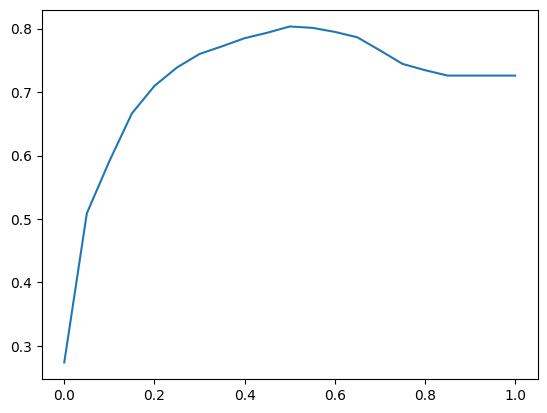

In [12]:
# let's visualize results:
plt.plot(thresholds, scores)

We can see that Threshold = 0.5 has highest Accuracy score

In [13]:
from sklearn.metrics import accuracy_score

The interesting observation we can make, is located at the Last point of the Graph:  
- there we make a decision, that the customer is going to churn by Prob >= 1, and we have accuracy around 70%,  
- however, there are no such values in the Validation dataset:

In [14]:
(y_pred >= 1).sum()

0

In [15]:
# Using Counter:
from collections import Counter

Counter(y_pred >= 1)

Counter({False: 1409})

We can see that there are only False values in that case

- Dummy model - in this example we gave only negative predictions only, but still got 73 % accuracy!

the reason for this is inside of classes distribution:

In [16]:
# distribution of y:
Counter(y_val)

Counter({0: 1023, 1: 386})

we can see that there are a lot more non-churning users then others, dummy model simply missing all churning users

This is due to the Class imbalance (3:1 non-churning/churning) 

therefore, accuracy cannot be the only model performance metric especially for Class imbalance cases and we need some other Metrics to Measure model's quality

# Confusion table

- different types of errors and correct decisions
- arranging these types into a table

![](./pic/1.png)

![](./pic/2.png)

![](./pic/3.png)

In [17]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [18]:
# combine them into an arrays:
tp = (predict_positive & actual_positive).sum() # true positive
tn = (predict_negative & actual_negative).sum() # true negative

fp = (predict_positive & actual_negative).sum() # false positive
fn = (predict_negative & actual_positive).sum() # false negative

print(f'true positive = {tp}')
print(f'true negative = {tn}')
print(f'false positive = {fp}')
print(f'false negative = {fn}')

true positive = 210
true negative = 922
false positive = 101
false negative = 176


![](./pic/4.png)

In [19]:
# confusion matrix:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[922, 101],
       [176, 210]])

it seems that it is more difficult to catch false negative errors

In [20]:
# we can also normalize it:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

![](./pic/5.png)

here instead of just 1 number we have 4 numbers to understand how good our model is and we can derive other metrics from these numbers

# Precision and Recall

In [21]:
# we can define accuracy as:
(tp + tn) / (tp + tn + fp + fn)

0.8034066713981547

- Precision - what fraction of Positive predictions are correct
$$ Precision = \frac{TP}{(TP+FP)} $$

![](./pic/6.png)

![](./pic/7.png)

In [22]:
# presicion calc:
p = tp / (tp + fp)

print(f'precision = {p}')
print(f'we say that {tp + fp} people are going to churn')
print(f'however, only {tp} are actually churn, and {fp} are errors')
print(f'therefore in {round(p*100, 3)}% of cases Positive predictions we were correct and in {round((1-p)*100, 3)}% wrong')

precision = 0.6752411575562701
we say that 311 people are going to churn
however, only 210 are actually churn, and 101 are errors
therefore in 67.524% of cases Positive predictions we were correct and in 32.476% wrong


- Recall - Fraction of Correctly identified Positive Observations  
we pay attention to the Positive Observations (not predictions)
$$ Recall = \frac{TP}{TP + FN} $$

![](./pic/8_.png)

![](./pic/9.png)

In [23]:
# Recall calculation:
r = tp / (tp+fn)
print(f'recall = {r}')
print(f'totally {tp+fn} people were actually going to churn')
print(f'and we found {tp} of them, therefore {fn} people were lost')
print(f'so we found {round((r*100),3)}% of people who were going to churn and we lost {round((1-r)*100, 3)}% of churn users')

recall = 0.5440414507772021
totally 386 people were actually going to churn
and we found 210 of them, therefore 176 people were lost
so we found 54.404% of people who were going to churn and we lost 45.596% of churn users


So, we can see that even though the accuracy is quite high, the Precision and Recall are not really good and, since our Primary task is Churn prediction, we can say that our model is not good enough

![](./pic/10.png)

# ROC Curves  
- ROC (receiver operating characteristics). It is used to describe the performance of Binary classification models

- FPR (False Positive Rate) - fraction of False Positive predictions among all actual negative observations:  
$$ FPR = \frac{FP}{FP + TN} $$

![](./pic/11.png)

- TPR - fraction of True Positive predictions among all Positive Observations (= recall):  
$$ TPR = \frac{TP}{TP + FN} $$

![](./pic/12.png)

- we want to make FPR as small as possible (reduce number of False positive)  
- and for TPR we want to make it as big as possible (increase number of True positive)

ROC curves are based on these 2 values (TPR and FPR)

In [24]:
# let's compute TRP and FPR:
tpr = tp / (tp + fn) # we want to maximize
fpr = fp / (fp + tn) # - we want to minimize

print(f'TPR = {tpr}')
print(f'FPR = {fpr}')

TPR = 0.5440414507772021
FPR = 0.09872922776148582


We produced these values for Threshold = 0.5,  
ROC Curve in turn computes these values for different thresholds

In [25]:
# compute FPR and TPR for different t:
thresholds = np.linspace(0, 1, 101)
scores = []
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative == (y_val == 0)
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    scores.append((t, tp, fp, fn, tn))

In [26]:
df_scores = pd.DataFrame(scores)
df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores['tpr'] = df_scores['tp'] / (df_scores['tp'] + df_scores['fn'])
df_scores['fpr'] = df_scores['fp'] / (df_scores['fp'] + df_scores['tn'])
df_scores

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.00,386,1023,0,0,1.000000,1.000000
1,0.01,385,913,1,110,0.997409,0.892473
2,0.02,384,830,2,193,0.994819,0.811339
3,0.03,383,766,3,257,0.992228,0.748778
4,0.04,381,715,5,308,0.987047,0.698925
...,...,...,...,...,...,...,...
96,0.96,0,0,386,1023,0.000000,0.000000
97,0.97,0,0,386,1023,0.000000,0.000000
98,0.98,0,0,386,1023,0.000000,0.000000
99,0.99,0,0,386,1023,0.000000,0.000000


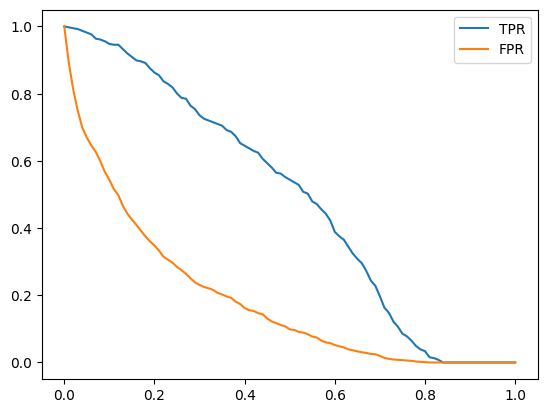

In [27]:
plt.plot(df_scores['threshold'], df_scores['tpr'], label='TPR')
plt.plot(df_scores['threshold'], df_scores['fpr'], label='FPR')
plt.legend()

- we want to have FPR at minimum
- and TPR to have at maximum   

for analysis we also need some sort of base line: we will use **random model** (model that randomly stays predictions)

# Random model   

In [28]:
np.random.seed(1)
y_rand = np.random.uniform(0,1, size=len(y_val))
y_rand

array([4.17022005e-01, 7.20324493e-01, 1.14374817e-04, ...,
       7.73916250e-01, 3.34276405e-01, 8.89982208e-02])

In [29]:
# accuracy of random model:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

in 50 % of case just by luck model got it's predictions

so now we also want to plot the same curves for random model

In [30]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [31]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)
df_rand

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.00,386,1023,0,0,1.000000,1.000000
1,0.01,382,1013,4,10,0.989637,0.990225
2,0.02,379,993,7,30,0.981865,0.970674
3,0.03,375,979,11,44,0.971503,0.956989
4,0.04,372,969,14,54,0.963731,0.947214
...,...,...,...,...,...,...,...
96,0.96,14,41,372,982,0.036269,0.040078
97,0.97,11,36,375,987,0.028497,0.035191
98,0.98,8,19,378,1004,0.020725,0.018573
99,0.99,6,7,380,1016,0.015544,0.006843


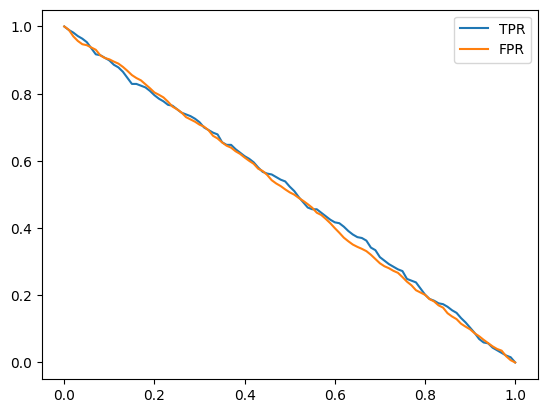

In [32]:
plt.plot(df_rand['threshold'], df_rand['tpr'], label='TPR')
plt.plot(df_rand['threshold'], df_rand['fpr'], label='FPR')
plt.legend()

so the ROC curve is almost a straight line, since it is random,  
- for t = 0.6, value = 0.4 for both TPR and FPR, reason for that is that at this t in 40% of cases model predicts that the customer is churning, and in 60% that is not churning, so for the customer that is going to churn, model has 40% chance to predict that

# Ideal model  
- model, which after ordering the probabilities always stays users that are actually negative 1st and then all users that are actually positive and the end

![](./pic/13.png)

in other words it is the model, that if we choose the proper Threshold would give 100% accurate predictions

In [33]:
# number of negative values in actual data:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

so now we can make synthetic predictions that follows this rule:

In [34]:
# ideal model decisions:  
y_ideal = np.repeat([0, 1], [num_neg, num_pos]) # 1023 of zeros and then 386 of ones
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

it is kind of repeat y_val, but in the another order

In [35]:
# now we can make predictions (could be any numbers between 0 and 1):
y_ideal_pred = np.linspace(0, 1, len(y_val))
y_ideal_pred

array([0.00000000e+00, 7.10227273e-04, 1.42045455e-03, ...,
       9.98579545e-01, 9.99289773e-01, 1.00000000e+00])

In [36]:
# accuracy 
(y_ideal == (y_ideal_pred >= 0.726)).mean()

1.0

In [37]:
# now we can also plot ROC curves for ideal model predictions:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


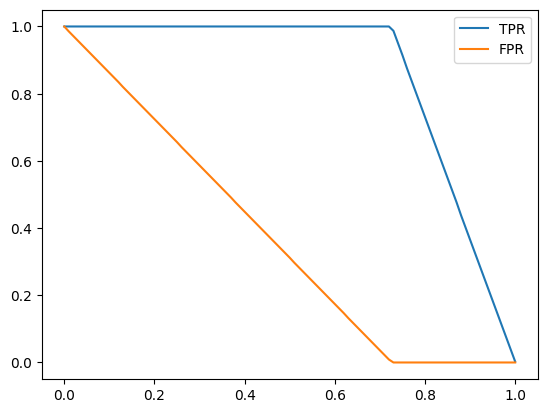

In [38]:
plt.plot(df_ideal['threshold'], df_ideal['tpr'], label='TPR')
plt.plot(df_ideal['threshold'], df_ideal['fpr'], label='FPR')
plt.legend()

## Putting everithing together

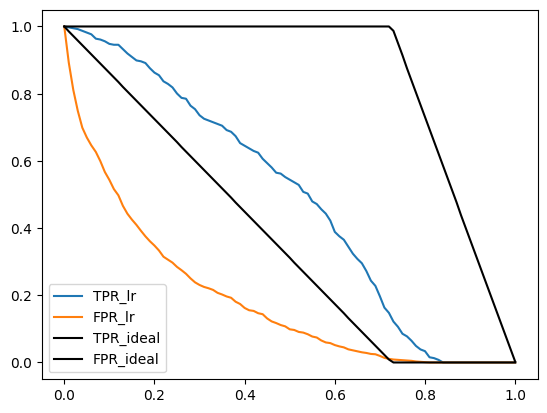

In [39]:
plt.plot(df_scores['threshold'], df_scores['tpr'], label='TPR_lr')
plt.plot(df_scores['threshold'], df_scores['fpr'], label='FPR_lr')

#plt.plot(df_rand['threshold'], df_rand['tpr'], label='TPR_rand')
#plt.plot(df_rand['threshold'], df_rand['fpr'], label='FPR_rand')

plt.plot(df_ideal['threshold'], df_ideal['tpr'], label='TPR_ideal', color='black')
plt.plot(df_ideal['threshold'], df_ideal['fpr'], label='FPR_ideal', color='black')
plt.legend()

![](./pic/14.png)

we want our model to be as close as possible to the ideal, but we can see that in reality our model is far from ideal,  
- also, such comparison may be not intuitive in some way, because they have different thresholds

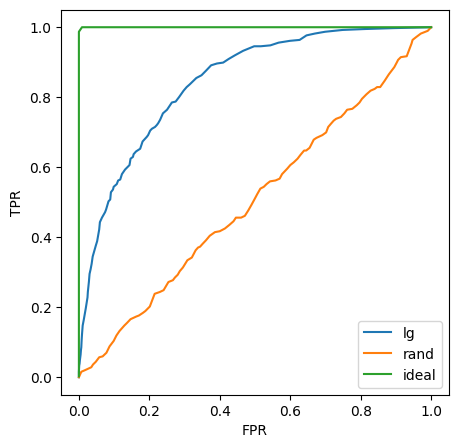

In [40]:
plt.figure(figsize=(5,5))

plt.plot(df_scores['fpr'], df_scores['tpr'], label='lg')
plt.plot(df_rand['fpr'], df_rand['tpr'], label='rand')
plt.plot(df_ideal['fpr'], df_ideal['tpr'], label='ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

![](./pic/16.png)

that is how we can compare different models to each other, the close the shape of model's ROC curve to the Ideal model, the better

ROC curves are good on their on, but there are also metrics that can be derived from them

In [41]:
# we can calculate ROC curves from sklearn library:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

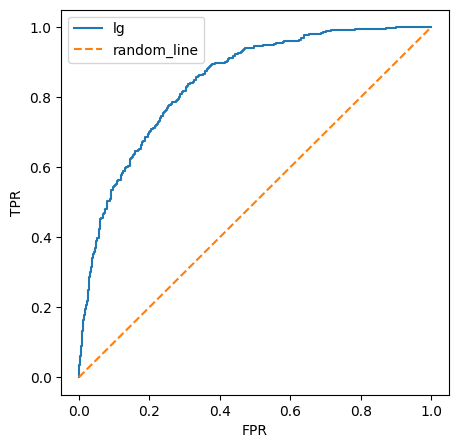

In [42]:
plt.figure(figsize=(5,5))

# we use output from the sklearn function
plt.plot(fpr, tpr, label='lg')
# random model we change to the [0,1], [0, 1] straight line:
plt.plot([0, 1], [0, 1], label='random_line', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

# ROC AUC
- AUC Area Under Curve, ROC AUC - area under ROC curve - useful metric
- Interpretation of AUC

![](./pic/17.png)

the closer the Model to the ideal one, the greater the AUC will be, therefore we can compare different models by this parameter

![](./pic/18.png)

we can calc AUC by sklearn, however it is not designed specifically for ROC curve, it can be used for any Curve

In [43]:
# calc roc auc:
from sklearn.metrics import auc
auc(fpr, tpr)

0.8438454408703446

In [44]:
# compare with hand coded results:
auc(df_scores['fpr'], df_scores['tpr'])

0.8438796286447967

In [45]:
# roc auc score for ideal model:
auc(df_ideal['fpr'], df_ideal['tpr'])

0.9999430203759136

for ideal model roc auc score is close to 1

above we did this calculation in 2 lines, however in sklearn there is a short cut for that:

In [46]:
from sklearn.metrics import roc_auc_score

In [47]:
roc_auc_score(y_val, y_pred)

0.8438454408703446

### AUC interpretation

![](./pic/19.png)

- so, if we take all users from the validation dataset
- then we randomly pick pairs of Churning-Non Churning users, we would have many pairs in which usually Probability of actually positive user has prep_proba > than non churning user
- Probability that actually churning user has prep_proba > than actually non-churning user - is ROC AUC score!

In [48]:
# let's see it in code:

# select all the score for actually negative clients (non churning):
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

import random

pos_ind = random.randint(0, len(pos) - 1) # select random positive example
neg_ind = random.randint(0, len(pos) - 1) # select random negative example

# now we want to compare scores between these examples:
pos[pos_ind] > neg[neg_ind]

False

in this case it is True, so we can repeat this procedure for 1000 times for example:


In [49]:
n = 100000
success = 0

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1) # select random positive example
    neg_ind = random.randint(0, len(pos) - 1) # select random negative example
    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1 # every time we succeed we increment counter

In [50]:
success / n

0.84937

so in 1000 tries we had 853 True values, therefore ROC AUC in this example is 84,92 %

so ROC AUC score is metric that describes how our model can sort customers properly,  
obviously, for Ideal model (users are ordered perfectly, therefore users who are going to churn would always have higher score), therefore ROC AUC score for ideal model would be = 1

In [51]:
# we can make the same analysis in the vectorized way:
n = 50000

np.random.seed(1)

pos_ind = np.random.randint(0, len(pos), size=n) # array with random numbers
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

0.84646

# Cross-validation

- Evaluating the same model on different subsets of data
- Getting the average prediction and the spread within predictions

Now we will talk about **Parameter Tuning** - process of selecting the best parameter

- it is possible to split entire dataset into 3 parts (train, validation and test)
- then we forget about test
- train the model, and then tune it on validation dataset

however, it is not the only possible option for Parameter tuning

- we can take full_tain dataset (train+validation),
- then we can split full_train into 3 folds (parts), 

![](./pic/20.png)

In [52]:
def train(df_train, y_train):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [53]:
dv, model = train(df_train, y_train)

In [54]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]

    return y_pred

In [55]:
y_pred = predict(df_val, dv, model)

In [56]:
# cross validation:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In [57]:
train_idx, val_idx = next(kfold.split(df_full_train))

In [58]:
len(train_idx)

5070

In [59]:
len(df_full_train)

5634

In [60]:
df_train = df_full_train.iloc[train_idx] # example of selecting train dataset from some iteration
df_val = df_full_train.iloc[val_idx]

then, when we have these datasets we can make the usual procedure of training, tuning and evaluating the model

but now we can iterate by KFolds generator:

In [63]:
from tqdm.auto import tqdm

C:\Users\abal\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [64]:
# iterate by kfolds:

scores = []
for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train['churn'].values
    y_val = df_val['churn'].values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
    print('%.3f' % auc)

1it [00:00,  5.11it/s]

0.848


2it [00:00,  4.87it/s]

0.840


4it [00:00,  4.28it/s]

0.857
0.833


6it [00:01,  4.66it/s]

0.825
0.834


8it [00:01,  5.33it/s]

0.841
0.819


10it [00:02,  5.41it/s]

0.845
0.862


10it [00:02,  4.92it/s]


In [65]:
print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.840 +- 0.013


Now we can add Regularization parameter to our model:

In [66]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(max_iter=1000, C=C)
    model.fit(X_train, y_train)

    return dv, model

It is worth noting that the C parameter here is the Opposite of the regularization power, the Higher the C the lower the regularization power

In [67]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]

    return y_pred

In [68]:
y_val

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,

In [69]:
# use different C values:
n_splits=5
for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = df_train['churn'].values
        y_val = df_val['churn'].values
    
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

 14%|█▍        | 1/7 [00:00<00:05,  1.01it/s]

C=0.001 0.825 +- 0.009


 29%|██▊       | 2/7 [00:01<00:04,  1.09it/s]

C=0.01 0.840 +- 0.009


 43%|████▎     | 3/7 [00:02<00:03,  1.10it/s]

C=0.1 0.841 +- 0.008


 57%|█████▋    | 4/7 [00:03<00:02,  1.09it/s]

C=0.5 0.840 +- 0.007


 71%|███████▏  | 5/7 [00:04<00:01,  1.12it/s]

C=1 0.840 +- 0.009


 86%|████████▌ | 6/7 [00:05<00:00,  1.11it/s]

C=5 0.841 +- 0.008


100%|██████████| 7/7 [00:06<00:00,  1.10it/s]

C=10 0.841 +- 0.008


The default C=1 is seems to be the best option

So we can use this parameter for final model

In [70]:
dv, model = train(df_full_train, df_full_train['churn'], C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8572386167896259

1 % higher score on testing dataset is ok

when it is better to use cross-validation or hold-out dataset?:
- depending on the size of dataset
    - Usually hold-out dataset is fine: when dataset is large enough, we can simply hold part of dataset for validation
    - when dataset is smaller or we want to have STD of score to see how stable the model is, we can use cross-validation
        - for bigger datasets number of folds could be 2/3 and
        - for smaller datasets number of folds could be 10

# Additional experiments

- Let us check the Precision and Recall of the dummy classifier that always predict "FALSE"

In [71]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [72]:
dummy_pred = np.zeros(len(y_val)) # array with zeros
precision_dummy = precision_score(y_val, dummy_pred)
recall_dummy = recall_score(y_val, dummy_pred)
print(f'precision of dummy model = {precision_dummy}')
print(f'recall of dummy model = {recall_dummy}')

precision of dummy model = 0.0
recall of dummy model = 0.0


C:\Users\abal\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


So, we can see that these metrics allow us to see that this simplified classifier that always predicts False can not have any score of precision or recall

# F1 score

- F1 score - is the weighted average of Precision and Recall.  
therefore, this score takes both False-positives and False-negatives into account.  
Intuitively it is not as easy to understand as Accuracy, but F1 much more useful, especially on the Uneven class distribution

In [73]:
y_pred_decision = (y_pred >= 0.5).astype(int)

In [74]:
# f1 formula:
def calculate_f1_score(y_test, y_pred):
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1_score = 2 * precision * recall / (precision + recall)
    return f1_score

In [75]:
model

LogisticRegression(max_iter=1000)

In [76]:
calculate_f1_score(y_test, y_pred_decision)

0.6060606060606061

In [77]:
# compare results with sklearn function:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred_decision)

0.6060606060606061

# Precision/Recall curve

- we will evaluate Precision and Recall at different Thresholds and plot P vs R to produce Precision/Recall curve

In [78]:
y_pred

array([0.06224296, 0.17473875, 0.37026701, ..., 0.00638005, 0.16576097,
       0.59688521])

In [79]:
# iterate through different thresholds:
thresholds_list = list(np.linspace(0, 1, 100))
precisions_list = []
recalls_list = []
for threshold in thresholds_list:
    y_pred_decision = (y_pred >= threshold).astype('int')
    precision_iter = precision_score(y_test, y_pred_decision, zero_division=0)
    recall_iter = recall_score(y_test, y_pred_decision, zero_division=0)
    precisions_list.append(precision_iter)
    recalls_list.append(recall_iter)
    print(f'thres = {round(threshold, 3)}, precision={round(precision_iter, 3)}, recall = {round(recall_iter, 3)}')

thres = 0.0, precision=0.247, recall = 1.0
thres = 0.01, precision=0.268, recall = 0.997
thres = 0.02, precision=0.283, recall = 0.989
thres = 0.03, precision=0.299, recall = 0.989
thres = 0.04, precision=0.308, recall = 0.989
thres = 0.051, precision=0.321, recall = 0.983
thres = 0.061, precision=0.329, recall = 0.977
thres = 0.071, precision=0.343, recall = 0.974
thres = 0.081, precision=0.358, recall = 0.968
thres = 0.091, precision=0.372, recall = 0.966
thres = 0.101, precision=0.382, recall = 0.963
thres = 0.111, precision=0.391, recall = 0.96
thres = 0.121, precision=0.4, recall = 0.954
thres = 0.131, precision=0.412, recall = 0.951
thres = 0.141, precision=0.417, recall = 0.943
thres = 0.152, precision=0.428, recall = 0.937
thres = 0.162, precision=0.431, recall = 0.928
thres = 0.172, precision=0.438, recall = 0.914
thres = 0.182, precision=0.447, recall = 0.902
thres = 0.192, precision=0.448, recall = 0.885
thres = 0.202, precision=0.453, recall = 0.862
thres = 0.212, precision

<AxesSubplot: xlabel='recall', ylabel='precision'>

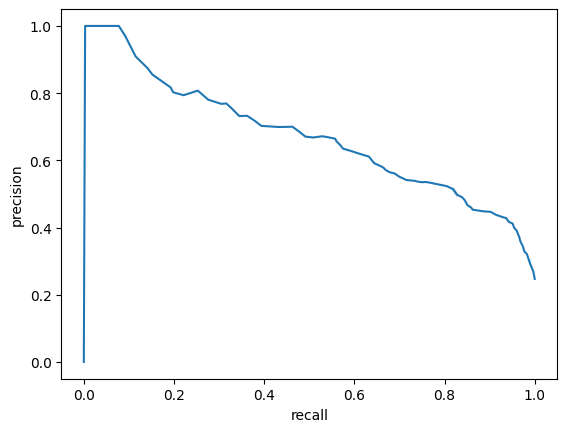

In [80]:
# plot precision/recall graph:
prec_recall_df = pd.DataFrame({
    'threshold': thresholds_list,
    'precision': precisions_list,
    'recall': recalls_list
})

#sns.lineplot(data=prec_recall_df, x='threshold', y='recall')
#sns.lineplot(data=prec_recall_df, x='threshold', y='precision')
sns.lineplot(data=prec_recall_df, x='recall', y='precision')

In [81]:
# now let's compare our results with random and ideal models
random_pred = np.random.random(size=len(y_test))
ideal_pred = np.linspace(0, 1, len(y_test))

In [82]:
# iterate through different thresholds:
thresholds_list = list(np.linspace(0, 1, 100))
precisions_list = []
recalls_list = []
precisions_random = []
recalls_random = []
precisions_ideal = []
recalls_ideal = []
for threshold in thresholds_list:
    # decisions:
    y_pred_decision = (y_pred >= threshold).astype('int')
    random_decision = (random_pred >= threshold).astype('int')
    ideal_decision = (ideal_pred >= threshold).astype('int')
    #model:
    precision_iter = precision_score(y_test, y_pred_decision, zero_division=0)
    recall_iter = recall_score(y_test, y_pred_decision, zero_division=0)
    precisions_list.append(precision_iter)
    recalls_list.append(recall_iter)
    # random:
    precision_random_iter = precision_score(y_test, random_decision, zero_division=0)
    recall_random_iter = recall_score(y_test, random_decision, zero_division=0)
    precisions_random.append(precision_random_iter)
    recalls_random.append(recall_random_iter)
    #ideal:
    precision_ideal_iter = precision_score(y_test, ideal_decision, zero_division=0)
    recall_ideal_iter = precision_score(y_test, ideal_decision, zero_division=0)
    precisions_ideal.append(precision_ideal_iter)
    recalls_ideal.append(recall_ideal_iter)

In [83]:
df_vis = pd.DataFrame({
    'threshold': thresholds_list,
    'precision_model': precisions_list,
    'recall_model': recalls_list,
    'precision_random': precisions_random,
    'recall_random': recalls_random,
    'precision_ideal': precisions_ideal,
    'recall_ideal': recalls_ideal
})
df_vis

,threshold,precision_model,recall_model,precision_random,recall_random,precision_ideal,recall_ideal
0,0.000000,0.246984,1.000000,0.246984,1.000000,0.246984,0.246984
1,0.010101,0.268161,0.997126,0.246055,0.985632,0.248207,0.248207
2,0.020202,0.283361,0.988506,0.246744,0.979885,0.250000,0.250000
3,0.030303,0.298871,0.988506,0.246176,0.971264,0.250366,0.250366
4,0.040404,0.308244,0.988506,0.246505,0.962644,0.247781,0.247781
...,...,...,...,...,...,...,...
95,0.959596,0.000000,0.000000,0.245614,0.040230,0.298246,0.298246
96,0.969697,0.000000,0.000000,0.256410,0.028736,0.348837,0.348837
97,0.979798,0.000000,0.000000,0.250000,0.020115,0.344828,0.344828
98,0.989899,0.000000,0.000000,0.111111,0.002874,0.266667,0.266667
